In [1]:
import os

DISABLE_GPU = True
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
!pip install visualkeras

In [3]:
!pip install keras-contrib

In [4]:
# !conda install -c conda-forge mne -y
# !conda install -c conda-forge ann -y
# !conda install -c conda-forge ann_visualizer -y
# !conda install graphviz -y
# !conda install -c anaconda python-graphviz -y
# !conda install -c anaconda pydot -y

In [5]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import params
import data_loader
from models import cnn_0, cnn_2, cnn_lstm, cnn_crf, resnet_101v2, efficient_net_v2l, vgg_19
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from glob import glob
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from ann_visualizer.visualize import ann_viz
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import tensorboard
from tensorflow.keras.utils import to_categorical
import datetime
from tensorflow.keras.utils import plot_model
import visualkeras

In [6]:
x_train_ori, x_test_ori, y_train_ori, y_test_ori = data_loader.get_train_test_v2()

x_train -> (948, 30726, 23) (30726, 23)
y_train -> (238, 30726, 23)
x_test  -> (948,) ()
y_test  -> (238,)


In [7]:
x_train, y_train, x_test, y_test = x_train_ori, to_categorical(y_train_ori, params.NUM_CLASS), x_test_ori, to_categorical(y_test_ori, params.NUM_CLASS)

In [8]:
data_loader.show_shape(x_train, y_train, x_test, y_test)

x_train -> (948, 30726, 23) (30726, 23)
y_train -> (948, 5)
x_test  -> (238, 30726, 23) (30726, 23)
y_test  -> (238, 5)


In [9]:
MODEL_LIST = []

In [10]:
MODEL_LIST.append(cnn_0())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30726, 23)]       0         
                                                                 
 conv1d (Conv1D)             (None, 30722, 16)         1856      
                                                                 
 conv1d_1 (Conv1D)           (None, 30718, 16)         1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3839, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3839, 16)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3833, 32)          3616      
                                                             

In [11]:
NAME_LIST = ["cnn_0"]

In [12]:
HIST_LIST, TRAINED_MODEL = [], []

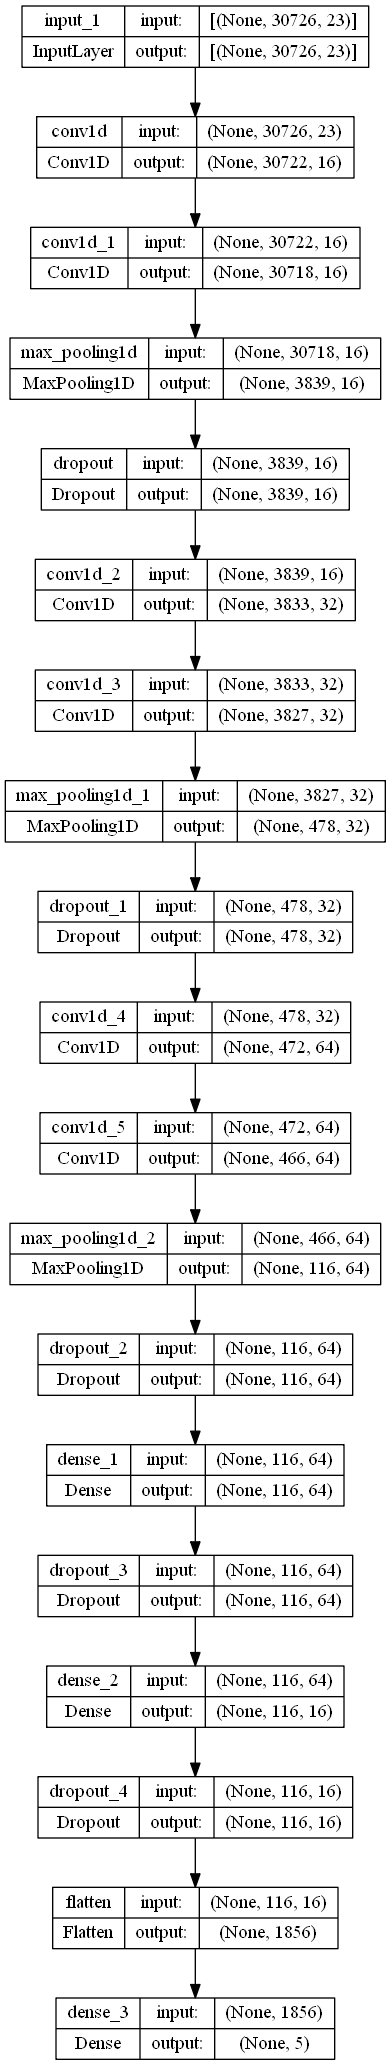

In [13]:
plot_model(MODEL_LIST[0], to_file="./images/" + NAME_LIST[0] + ".png", show_shapes=True, show_layer_names=True)

In [14]:
def get_callbacks(file_path, model_name):
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=20, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, verbose=2)
    log_dir = "logs/" + str(model_name) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tfboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks_list = [checkpoint, early, redonplat, tfboard]

In [15]:
def train_model(model, name):
    file_path = './models/' + name + "_" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + '.h5'
    callbacks_list = get_callbacks(file_path, name)
    opt = Adam(learning_rate=params.LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(x=x_train, y=y_train,
                        epochs=params.EPOCH_NUM,
                        batch_size=params.BATCH_SIZE,
                        validation_data=(x_test, y_test),
                        verbose=params.VERBOSE,
                        callbacks=callbacks_list)
#     model.save(file_path)
#     model = load_model(file_path)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Loss: ', test_loss)
    print('Accuracy: ', test_acc) 
    return history, model

In [16]:
for i in range(len(MODEL_LIST)):
    history, trained_model = train_model(MODEL_LIST[i], NAME_LIST[i])
    HIST_LIST.append(history)
    TRAINED_MODEL.append(trained_model)

Epoch 1/10
30/30 [==============================] - 13s 414ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 2/10
30/30 [==============================] - 11s 377ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 3/10
30/30 [==============================] - 11s 375ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 4/10
30/30 [==============================] - 11s 377ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 5/10
30/30 [==============================] - 11s 378ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 6/10
30/30 [==============================] - 11s 375ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 7/10
30/30 [==============================] - 11s 376ms/step - loss: nan - accuracy: 0.2384 - val_loss: nan - val_accuracy: 0.3277
Epoch 8/10
30/30 [=======================

In [17]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

In [18]:
def confusion_matrix_plot(matrix, classes, name):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./images/' + name + 'con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [19]:
def props_to_onehot(props):
    if isinstance(props, list):
        props = np.array(props)
    a = np.argmax(props, axis=1)
    b = np.zeros((len(a), props.shape[1]))
    b[np.arange(len(a)), a] = 1
    return b

In [20]:
def cal_score(model, name, plot=True, labels=[0, 1, 2, 3, 4]):
    predictions = np.argmax(props_to_onehot(model(x_test)), axis=1)
    labels = np.argmax(y_test, axis=1)
    print(predictions, labels)
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=params.CLASS))
    
    if plot:
        confusion_matrix_plot(matrix, params.CLASS, name)

In [21]:
def plot_and_f1(model, history, name):
    cal_score(model, name, plot=True)
    tr_plot(history, 0)
    print("=" * 80)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [2 0 0 2 1 4 4 0 3 0 0 2 2 0 0 3 1 2 4 2 0 4 3 0 2 3 0 2 0 0 2 0 2 0 3 0 2
 3 3 1 0 2 1 4 2 2 2 2 2 4 4 0 2 4 2 2 0 0 2 2 2 0 4 0 0 0 4 1 2 0 0 1 0 0
 0 3 4 4 2 4 2 0 0 2 2 2 0 0 3 0 0 4 2 2 0 0 4 0 1 0 2 4 0 4 2 2 2 1 0 2 0
 3 4 2 0 1 3 0 2 1 2 4 0 2 1 2 2 0 0 1 2 2 2 2 1 2 0 4 3 0 0 4 2 2 4 2 2 4
 2 2 3 2 0 2 2 0 2 3 0 2 3 0 4 0 1 4 2 0 4 1 2 1 0 3 0 4 2 3 0 0 2 0 2 0 2
 4 2 0 3 4 2 0 0 0 0 2 0 0 2 0 3 2 2 1 0 0 3 0 2 0 2 4 2 3 2 2 4 2 0 1 0 2
 4 2 2 2 3 2 2 0 2 4 2 4 0 0 3 2]
[[78 18 85 23 34]
 [ 0  0  0  0 

D:\Miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


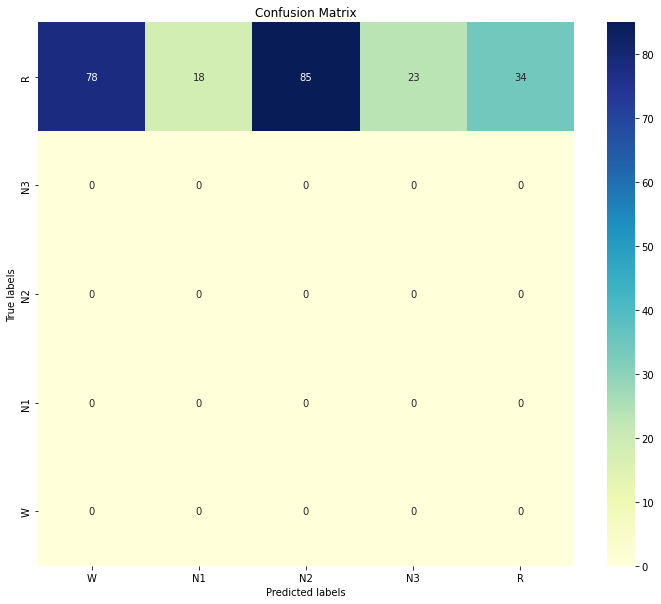

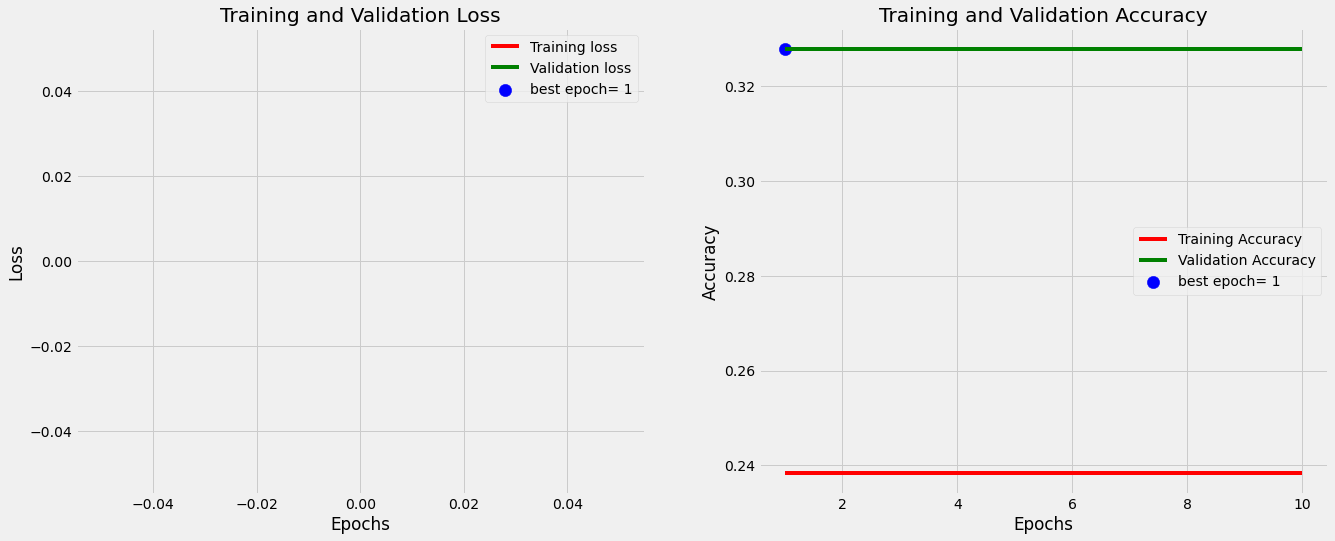

In [22]:
for i in range(len(HIST_LIST)):
    plot_and_f1(TRAINED_MODEL[i], HIST_LIST[i], NAME_LIST[i])